In [1]:
!git clone https://github.com/niazwazir/Wazir_Saadi_Localiaztion

Cloning into 'Wazir_Saadi_Localiaztion'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [2]:
!ls

sample_data  Wazir_Saadi_Localiaztion


In [3]:
import pandas as pd
df = pd.read_csv("Wazir_Saadi_Localiaztion/Dr_Saddi_Localization.csv") #unzip and read in data downloaded to the local directory
df.head(n=5) #just to check you imported the dataset properly

,Time,X,Y,Z,LED 1,LED 2,LED 3,LED 4,LED 5,LED 6,LED 7,LED 8,LED 9,LED 10,LED 11,LED 12,LED 13,LED 14,LED 15,LED 16,LED 17,LED 18,LED 19,LED 20,LED 21,LED 22,LED 23,LED 24,LED 25,LED 26,LED 27,LED 28,Amount,Class
0,0,0,0,0,8.272,3.625,4.993,2.560,2.653,1.596,8.272,3.625,4.993,2.560,2.653,1.596,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,4,0,0,8.705,3.885,5.194,2.712,2.730,1.671,8.705,3.885,5.194,2.712,2.730,1.671,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,8,0,0,9.134,4.162,5.390,2.872,2.804,1.748,9.134,4.162,5.390,2.872,2.804,1.748,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,12,0,0,9.554,4.456,5.579,3.040,2.875,1.826,9.554,4.456,5.579,3.040,2.875,1.826,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,16,0,0,9.959,4.768,5.758,3.214,2.941,1.907,9.959,4.768,5.758,3.214,2.941,1.907,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
!git clone https://github.com/curiousily/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras.git

Cloning into 'Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 73 (delta 2), reused 0 (delta 0), pack-reused 67
Unpacking objects: 100% (73/73), done.


In [5]:
!ls

Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras
sample_data
Wazir_Saadi_Localiaztion


In [6]:
cd Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras

/content/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras


In [7]:
!ls

data  fraud_detection.ipynb  LICENSE  logs  model.h5  README.md


In [8]:
cd data

/content/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras/data


In [9]:
!ls

creditcardfraud.zip


In [10]:
!unzip creditcardfraud.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [11]:
!ls

creditcard.csv	creditcardfraud.zip


In [12]:
cd ..

/content/Credit-Card-Fraud-Detection-using-Autoencoders-in-Keras


In [13]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Partial_Blocking", "Full_Blocking"]

Using TensorFlow backend.


In [0]:
df = pd.read_csv("data/creditcard.csv")

# Exploration

In [15]:
df.shape

(284807, 31)

31 columns, 2 of which are Time and Amount. The rest are output from the PCA transformation. Let's check for missing values:

In [16]:
df.isnull().values.any()

False

In [0]:
#count_classes = pd.value_counts(df['Class'], sort = True)
#count_classes.plot(kind = 'bar', rot=0)

In [0]:
Partial_Blocking = df[df.Class == 1]
Full_Blocking = df[df.Class == 0]

In [19]:
Full_Blocking.shape

(284315, 31)

In [20]:
Partial_Blocking.shape

(492, 31)

In [21]:
Full_Blocking.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [22]:
Partial_Blocking.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

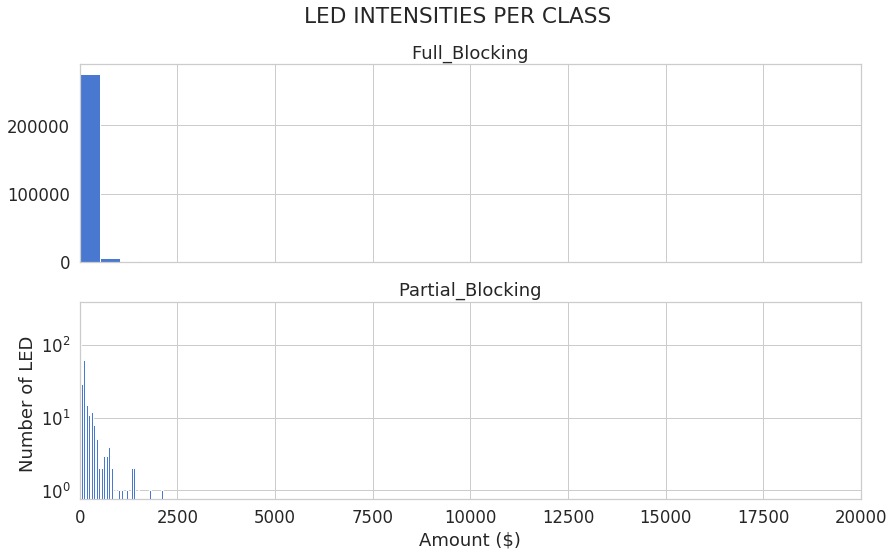

In [23]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('LED INTENSITIES PER CLASS')

bins = 50

ax1.hist(Full_Blocking.Amount, bins = bins)
ax1.set_title('Full_Blocking')

ax2.hist(Partial_Blocking.Amount, bins = bins)
ax2.set_title('Partial_Blocking')

plt.xlabel('Amount ($)')
plt.ylabel('Number of LED ')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

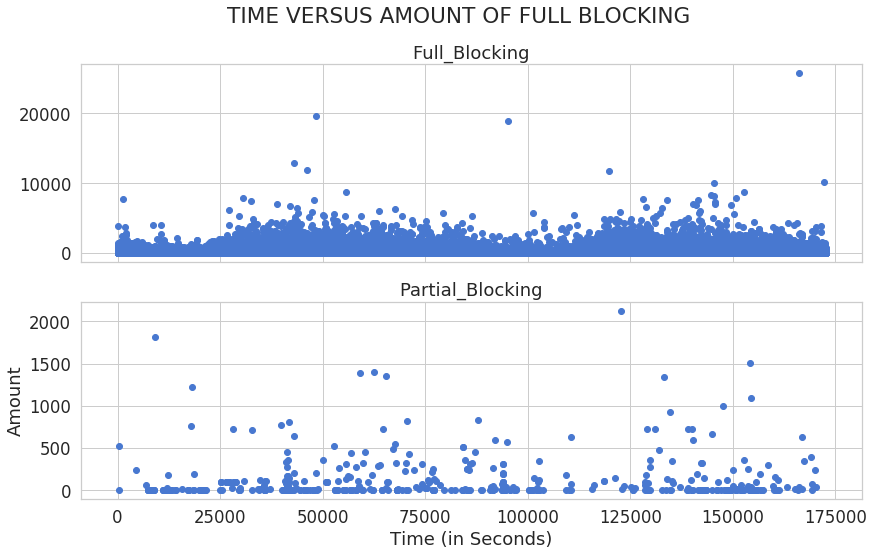

In [24]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('TIME VERSUS AMOUNT OF FULL BLOCKING')

ax1.scatter(Full_Blocking.Time, Full_Blocking.Amount)
ax1.set_title('Full_Blocking')

ax2.scatter(Partial_Blocking.Time, Partial_Blocking.Amount)
ax2.set_title('Partial_Blocking')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler

data = df.drop(['Time'], axis=1)

data['Amount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))

In [0]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
X_test = X_test.values

In [27]:
X_train.shape

(227451, 29)

In [0]:
input_dim = X_train.shape[1]
encoding_dim = 14

In [29]:
input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)

SaadiModel = Model(inputs=input_layer, outputs=decoder)

W0905 21:05:13.133690 140495455627136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0905 21:05:13.171236 140495455627136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0905 21:05:13.178706 140495455627136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [30]:
!git clone https://github.com/niazwazir/Wazir_Saadi_Localiaztion

Cloning into 'Wazir_Saadi_Localiaztion'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 11 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


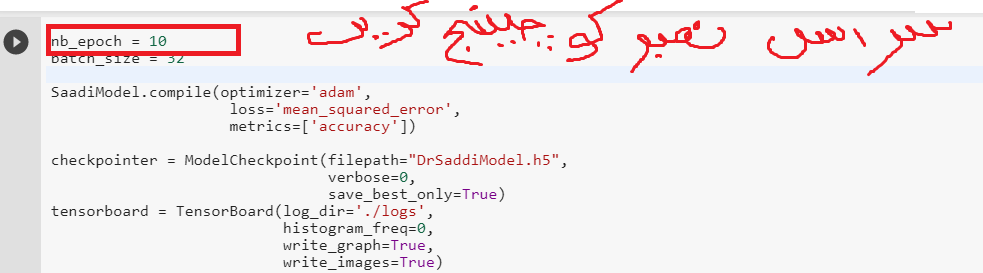

In [31]:
from IPython.display import Image
Image('Wazir_Saadi_Localiaztion/imag1.png')

In [33]:
nb_epoch = 10
batch_size = 32

SaadiModel.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="DrSaddiModel.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = SaadiModel.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 227451 samples, validate on 56962 samples
Epoch 1/10
227451/227451 [==============================] - 35s 155us/step - loss: 0.7544 - acc: 0.6496 - val_loss: 0.7758 - val_acc: 0.6591
Epoch 2/10
227451/227451 [==============================] - 35s 154us/step - loss: 0.7374 - acc: 0.6550 - val_loss: 0.7675 - val_acc: 0.6576
Epoch 3/10
227451/227451 [==============================] - 35s 154us/step - loss: 0.7296 - acc: 0.6611 - val_loss: 0.7653 - val_acc: 0.6600
Epoch 4/10
227451/227451 [==============================] - 35s 152us/step - loss: 0.7244 - acc: 0.6656 - val_loss: 0.7545 - val_acc: 0.6617
Epoch 5/10
227451/227451 [==============================] - 34s 151us/step - loss: 0.7222 - acc: 0.6698 - val_loss: 0.7527 - val_acc: 0.6589
Epoch 6/10
227451/227451 [==============================] - 35s 153us/step - loss: 0.7210 - acc: 0.6714 - val_loss: 0.7523 - val_acc: 0.6721
Epoch 7/10
227451/227451 [==============================] - 35s 154us/step - loss: 0.7191 - acc: 0.6742

In [34]:
SaadiModel.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 29)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 56        
_________________________________________________________________
dense_4 (Dense)              (None, 29)                232       
Total params: 813
Trainable params: 813
Non-trainable params: 0
_________________________________________________________________


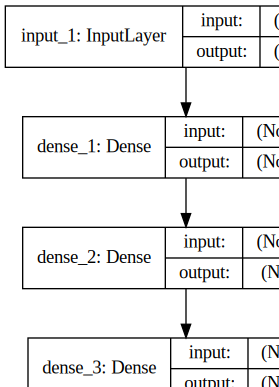

In [35]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(SaadiModel, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
autoencoder = load_model('DrSaddiModel.h5')

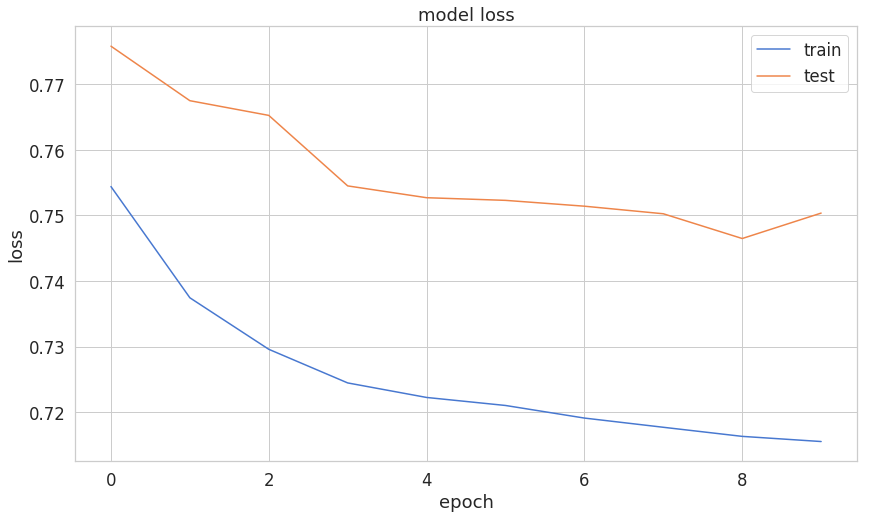

In [37]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

The reconstruction error on our training and test data seems to converge nicely. Is it low enough? Let's have a closer look at the error distribution:

In [0]:
predictions = autoencoder.predict(X_test)

In [0]:
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

In [40]:
error_df.describe()

,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,0.738969,0.001720
std,3.443063,0.041443
min,0.047621,0.000000
25%,0.247785,0.000000
50%,0.397428,0.000000
75%,0.636380,0.000000
max,273.397059,1.000000


## Reconstruction error without Full Blocking

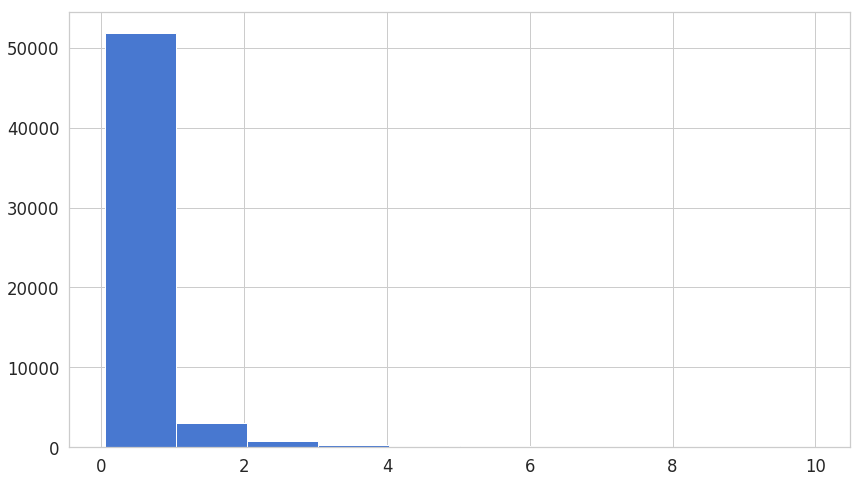

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

## Reconstruction error with Partial Blocking

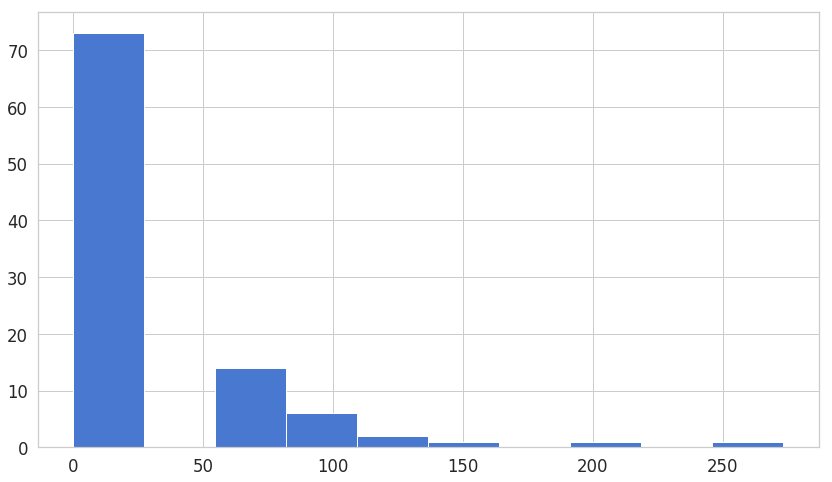

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [0]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

ROC curves are very useful tool for understanding the performance of binary classifiers. However, our case is a bit out of the ordinary. We have a very imbalanced dataset. Nonetheless, let's have a look at our ROC curve:

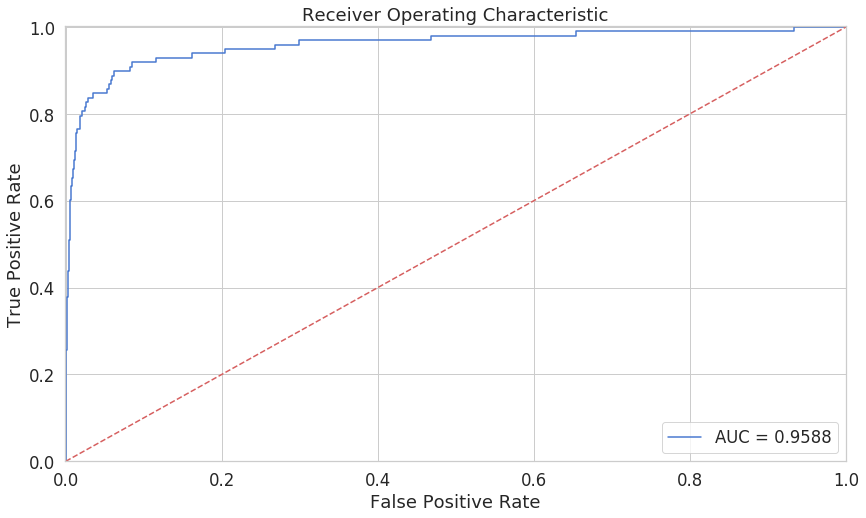

In [44]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [0]:
threshold = 2.9

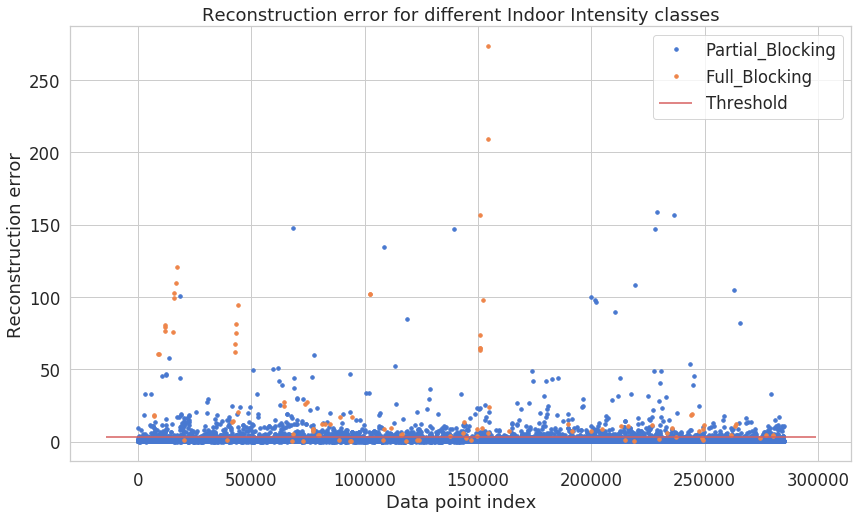

In [46]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Full_Blocking" if name == 1 else "Partial_Blocking")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different Indoor Intensity classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

I know, that chart might be a bit deceiving. Let's have a look at the confusion matrix:

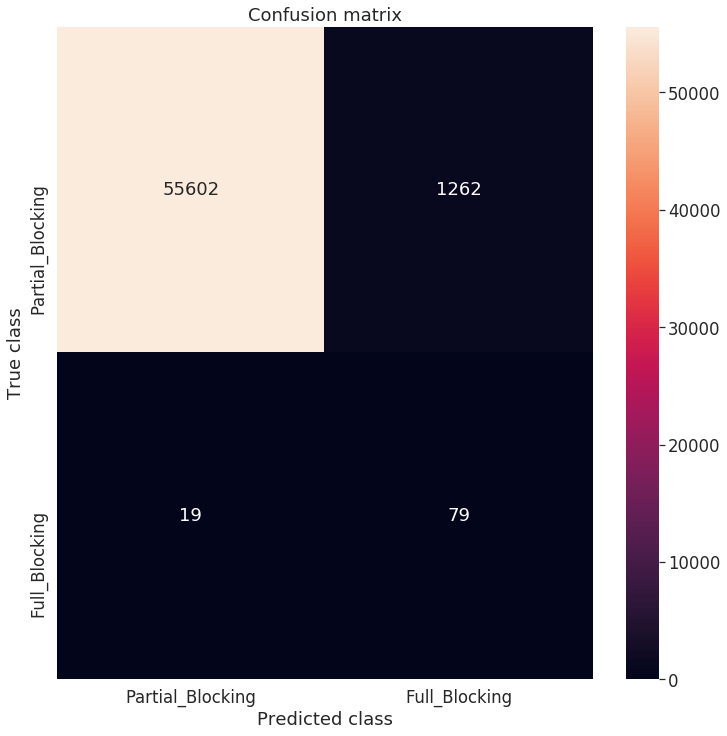

In [47]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()